# WATER BAG INCIDENTS IN RIO DE JANEIRO - PRELIMINARY CLUSTERING

---
### Notebook Sections:

1. Utility functions
1. Data Cleaning
2. Exploratory Data Analysis
3. Clustering Incidents

### Import modules and functions

In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Define data class to host data paths
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [ ]:
catalog = pd.read_csv('Dados/water_bag_catalog_google.csv', parse_dates=True, infer_datetime_format=True)

# Extract records of water bag formatioincidents (copy data for cleaning)
catalog = catalog[catalog['POP_TITULO']=="Bolsão d'água em via"].copy()
data = catalog.copy()

---
## 0. Utility functions

#### Functions to format and correct street number text variable

In [ ]:
from Modules.text_formatter import text_transform_pipeline, get_not_number, drop_letters, drop_space, drop_chars, split_avg

#### Plot colored and connected coordinates in 2D plane

In [ ]:
from Modules.coord_plot import (
    cmaps, connect_coordinates_colored,
    min_group_size_progression_plot,
    atemporal_evolution_plot
)

#### Cluster processing and plot function

In [ ]:
def filter_group_size(data, group_col, min_members=10):
    label_cnt = data[group_col].value_counts()
    top_labels = label_cnt[label_cnt > min_members].index
    top_msk = data[group_col].isin(top_labels)
    return data[top_msk]

def cluster_algo_comparison(x, y, data, algs, hide_outliers=False, title='{}/{}', figsize=(12, 7.5), n_cols=2): 
    fig = plt.figure(figsize=figsize, tight_layout=True)
    n_rows =  len(algs)//n_cols if len(algs)%n_cols==0 else len(algs)//2 + 1
    axs = (fig.add_subplot(n_rows, n_cols, i) for i in range(1, len(algs)+1))
    for ax, alg in zip(axs, algs):
        labels = np.unique(alg.labels_)
        for label in labels:
            if hide_outliers and label==-1: continue
            ax.scatter(x, y, data=data[alg.labels_==label])
        ax.set(title=title.format(type(alg).__name__, labels.shape[0]))
    return axs

def min_samples_clusters_animation(
    data, group_col, max_samples_stop=0.5, freq=0.1,
    coord_cols=['EVENTO_LONGITUDE', 'EVENTO_LATITUDE'], order_col='street_number',
    connect=False, scatter=True,
    cmap=None, figsize=(20, 12),
    title='Incident coordinates Connected and Colored Line & Scatter Plot',
):
    
    label_cnt = data[group_col].value_counts()
    max_samples = label_cnt.max()
    min_samples = label_cnt.min()
    size_range = max_samples - min_samples
    
    if type(max_samples_stop) is float:
        min_samples_i = min_samples + (np.arange(0, max_samples_stop, freq) * size_range).round(0)
    elif type(max_samples_stop) is int:
        min_samples_i = np.arange(min_samples, max_samples_stop+1, freq)
        
    for min_samples in min_samples_i:

        top_data = filter_group_size(data, group_col=group_col, min_members=min_samples)

        co(wait=True)
        connect_coordinates_colored(
            top_data[coord_cols[0]], top_data[coord_cols[1]],
            top_data[group_col], top_data[order_col], cmap=cmap,
            connect=connect, scatter=scatter,
            title=title,
            figsize=figsize,
        )


---
# 1. Data Cleaning

#### Format and correct street number variable

In [ ]:
not_number = get_not_number(catalog['street_number'])
not_number_corrected =  text_transform_pipeline(not_number, [drop_letters, drop_space, drop_chars, split_avg])

data.loc[not_number.index, ['street_number']] = not_number_corrected
data.dropna(subset=['street_number'], inplace=True) # drop rows where street number is missing

#### Data type conversion

In [ ]:
float_cols = ['EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'search_lat', 'search_lng', 'street_number']
data[float_cols] = data[float_cols].astype(float)

---
# 3.Clustering Incidents

##### Planning:
1. Cluster all points together
2. Cluster by street number
3. Cluster only routes with more than min_incidents
4. Cluster only routes with more than min_incident_density
5. Cluster only routes with number range above min_street_number_range

#### 0.2 Setting automatic clustering algorithms

In [180]:
from sklearn import cluster, mixture
from sklearn.preprocessing import MinMaxScaler as mms, LabelEncoder as le

mean = cluster.MeanShift(bandwidth=0.01, cluster_all=False, max_iter=1000)
agg = cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0.1)
dbscan = cluster.DBSCAN(eps=0.005, min_samples=3)
optics = cluster.OPTICS(max_eps=0.05, min_samples=3)
birch = cluster.Birch(threshold=0.01, branching_factor=5, n_clusters=None)
gaussian = mixture.GaussianMixture(
    n_components=250, covariance_type='full',
    tol=5e-4, reg_covar=1e-6,
    max_iter=500, n_init=1, verbose=1
)
bayesian = mixture.BayesianGaussianMixture(
    n_components=250, weight_concentration_prior=1e-3,
    covariance_type='full',
    tol=5e-4, reg_covar=1e-6,
    max_iter=500, n_init=1, verbose=1)

algs = [mean, agg, dbscan, optics, birch, gaussian, bayesian]

##### Algorithm source code and examples

In [ ]:
a = algs[6]
a?

### 1. Clustering multiple algorithms by geodetic coordinates

##### Fit different algorithms

In [181]:
coords = mms().fit_transform(data[['EVENTO_LONGITUDE', 'EVENTO_LATITUDE']])
unlabeld = ['GaussianMixture', 'BayesianGaussianMixture']

for i, alg in enumerate(algs[:]):
    name = type(alg).__name__
    print(f'{i+1}/{len(algs)} - {name} algorithm running...'); alg.fit(coords); co(wait=True)
    if name in unlabeld:
        alg.labels_ = alg.predict(coords)
print(f'Done! {len(algs)} cluster algorithms fitted.')

Done! 7 cluster algorithms fitted.


#### Compare performance of algorithms

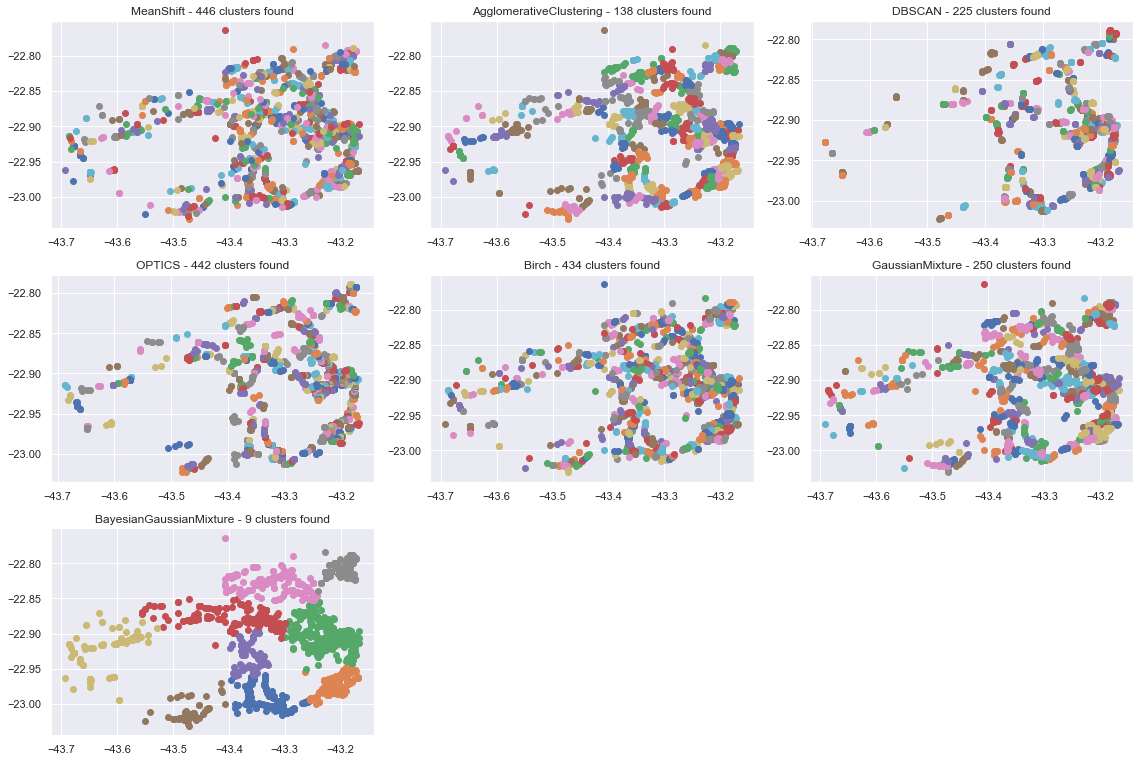

In [182]:
axs = cluster_algo_comparison(
    'EVENTO_LONGITUDE', 'EVENTO_LATITUDE',
    data, algs,
    hide_outliers=True,
    title='{} - {} clusters found',
    figsize=(16, 14), n_cols=3
)

#### Best auto algorithm - Clusters filtered by minimum number of samples

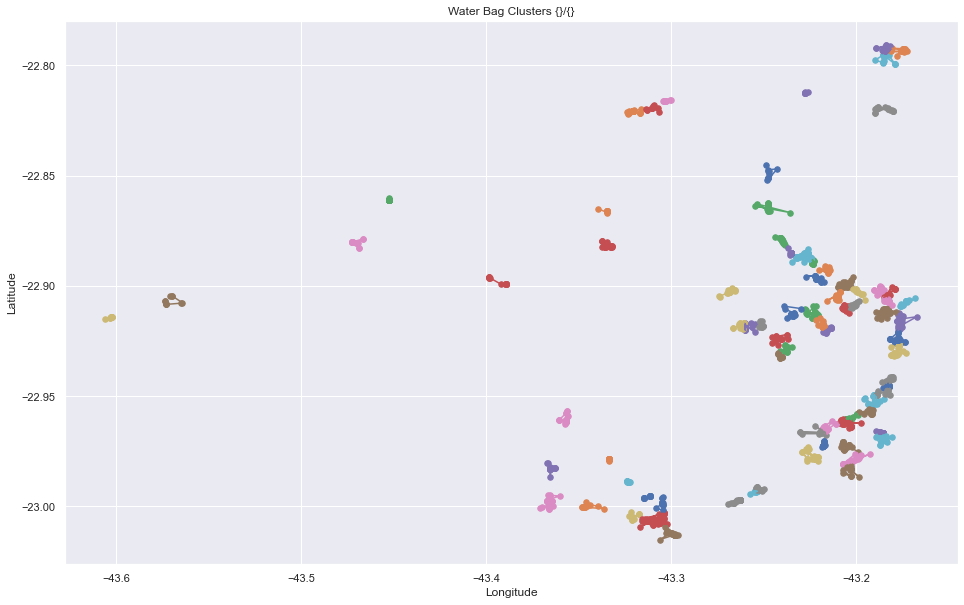

In [183]:
sel_alg = 4

data['label'] = algs[sel_alg].labels_
in_data = data[data['label'] != -1] # Excluding outlier samples
top_data = filter_group_size(in_data, group_col='label', min_members=10) # Excluing clusters with less then 'min_members' samples 

connect_coordinates_colored(
    top_data['EVENTO_LONGITUDE'], top_data['EVENTO_LATITUDE'],
    top_data['label'], top_data['street_number'], cmap=None,
    title='Water Bag Clusters {}/{}',
    figsize=(16, 10), connect=True
)

#### Clusters in folium map

In [184]:
import folium
from Modules.mapper import plot_markers

In [186]:
Map = folium.Map(
    location=[-22.9037, -43.4276], zoom_start=10,
    width='100%', height='100%', tiles='Stamen Terrain'
)

Map, LE = plot_markers(
    Map, top_data, radius=3,
    coord_cols=['EVENTO_LATITUDE', 'EVENTO_LONGITUDE'],
    group_col='label', cmap='tab20',
    exclude=[], touch_coord=True, return_encoder=True
)

Map

#### Excluding clusters by dinamic mininum number of samples per cluster - Animation

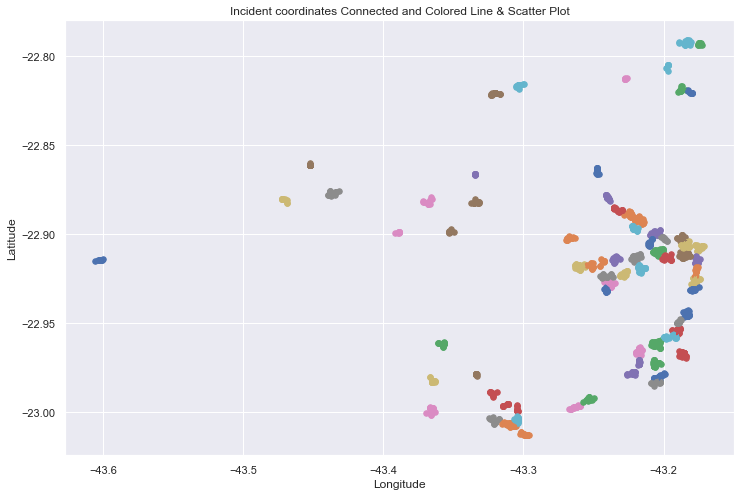

In [64]:
min_samples_clusters_animation(
    in_data, 'label',
    max_samples_stop=10, freq=1,
    figsize=(12, 8),
    connect=True
)

### 2. Evaluate cluster result

#### Number of clusters with at least 'min_samples'

In [148]:
len(top_data['label'].unique())

78

#### Cluster size distribution

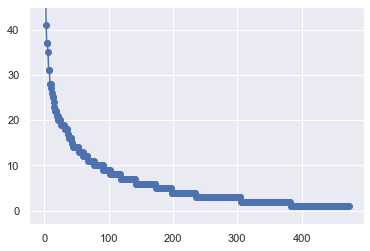

In [149]:
in_data['label'].value_counts().reset_index(drop=True).plot(ylim=(-3, 45), marker='o'); plt.show()

#### Routes per cluster

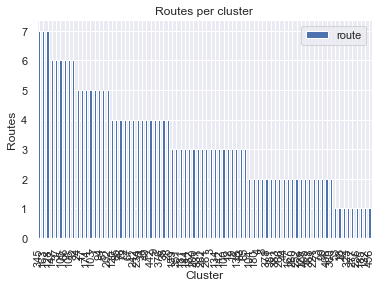

In [150]:
ax = top_data.groupby(['label'])[['route']].nunique().sort_values('route', ascending=False).plot.bar()
ax.set(title='Routes per cluster', ylabel='Routes', xlabel='Cluster')
plt.show()

#### Routes per cluster distribution

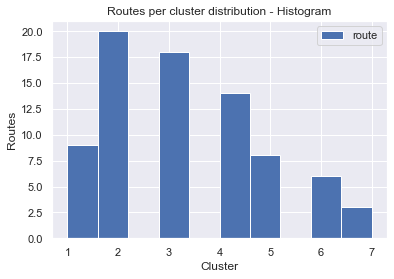

In [151]:
ax = top_data.groupby(['label'])[['route']].nunique().sort_values('route', ascending=False).plot.hist()
ax.set(title='Routes per cluster distribution - Histogram', ylabel='Routes', xlabel='Cluster')
plt.show()

### 4. Save best cluster result

Cluster info:
1. Cluster label
2. Cluster representative street
3. Cluster Centroid
4. Cluster box
5. Cluster box center
6. Cluster radius

In [19]:
from Modules.geometric_properties import clusters_geometry

clusters = data.set_index('EVENTO_ID')[['label']]

#### Join clusters' representative routes

In [20]:
cluster_route_cnt = data.groupby(['label', 'route'])[['EVENTO_ID']].count().sort_values(['label', 'EVENTO_ID'], ascending=[True, False])
cluster_top_routes = cluster_route_cnt.reset_index('route').groupby('label')['route'].first().to_dict()
cluster_route_map = lambda label: cluster_top_routes[label]

clusters['main_route'] = list(map(cluster_route_map, clusters['label']))

#### Join geometric properties

In [21]:
geometry = clusters_geometry(
    data['EVENTO_LATITUDE'], data['EVENTO_LONGITUDE'], clusters['label'],
    include_box=True, include_center_radius=True
)

clusters = clusters.join(geometry)

#### Save cluster labels and geometric properties

In [22]:
# clusters.to_csv('Dados/incident_clusters.csv', index=True)

clusters.head()

,label,main_route,lat_centroid,lng_centroid,lat_min,lat_max,lng_min,lng_max,lat_center,lng_center,horizontal_perimeter,vertical_perimeter,radius
EVENTO_ID,,,,,,,,,,,,,
1258,0,Praia de Botafogo,-22.944533,-43.182800,-22.946246,-22.941320,-43.185848,-43.180029,-22.943783,-43.182939,545.554345,596.804890,298.402445
1259,-1,Avenida das Américas,-22.908780,-43.340046,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964
1260,-1,Avenida das Américas,-22.908780,-43.340046,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964
1261,-1,Avenida das Américas,-22.908780,-43.340046,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964
1263,1,Avenida Rio de Janeiro,-22.892384,-43.216725,-22.893985,-22.889982,-43.220700,-43.214200,-22.891984,-43.217450,443.346533,666.925550,333.462775


### 5. Analysis of clusters' geometry results

In [23]:
top_clusters = clusters.loc[top_data['EVENTO_ID']]

#### Samples per cluster

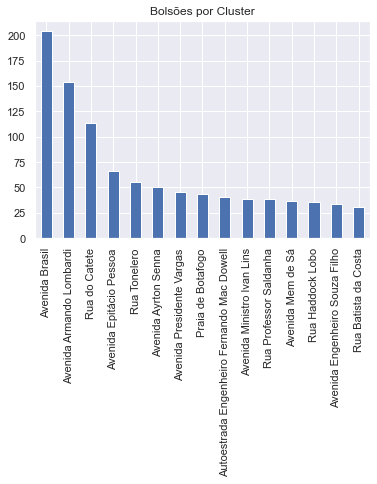

In [24]:
ax = top_clusters['main_route'].value_counts().head(15).plot.bar(title='Bolsões por Cluster'); plt.show()

#### Cluster radius statistical description

In [25]:
(top_clusters[['radius']]).describe()

,radius
count,1574.000000
mean,293.541305
std,183.088563
min,5.614172
25%,181.305257
50%,268.385599
75%,343.504509
max,707.378852


In [26]:
from Modules.mapper import plot_markers, draw_circles, draw_rectangles

In [28]:
areas = clusters.groupby('label').first().loc[top_data['label'].unique()]
areas['radius'] = areas['radius'] / 1000

In [29]:
Map = folium.Map(
    location=[-22.9037, -43.4276], zoom_start=10,
    width='100%', height='100%', tiles='Stamen Terrain'
)

Map, LE = plot_markers(
    Map, top_data, radius=3,
    coord_cols=['EVENTO_LATITUDE', 'EVENTO_LONGITUDE'],
    group_col='label', cmap='tab20',
    exclude=[], touch_coord=True, return_encoder=True
)

# Map = draw_circles(
#     Map, areas,
#     loc=['lat_center', 'lng_center'], radius='radius',
#     popup='main_route', tooltip='main_route',
#     cmap='tab20', lut=len(areas), LE=LE,
#     stroke=True, weight=4, fill=True,
#     fill_color=None, fill_opacity=.3
# )

Map = draw_rectangles(
    Map, areas,
    loc=[['lat_min', 'lng_min'], ['lat_max', 'lng_max']],
    popup='main_route', tooltip='main_route',
    cmap='tab20', lut=len(areas), LE=LE,
    stroke=True, weight=3, fill=True,
    fill_color=None, fill_opacity=.3
)

In [30]:
Map